This notebook allows for wholistic qualitative and quantitative evaluation of nuclear segmentation performance of multiple segmentation platforms on a sampled ROI from multiplexed stained whole slide images. Prior to running this notebook, ensure that binary nuclear masks have been generated for all the fields you have sampled from the dataset. Instructions for this can be found in the `segmentation` module of the repository. There should be one binary mask from each segmentation platform for a field. Next, put all the binary masks for one field in a directory, and all the binary masks for another field in a different directory. As a result, there should be one directory for each field, where the directories contain the binary nuclear masks from the platforms being evaluated. Please note that all masks should be tiff files.

The next step is to sample a sub-field for evaluation from each field and record their (upper-left-hand) coordinates. Ground truth nuclear annotations can then be created in GIMP for the subfields.

In GIMP, load the gray scaled DAPI channel for the field and crop the image according to the coordinates for the first evaluation sub-field. Add a new layer over the DAPI image with a medium level of opacity so that the DAPI signal can still be clearly visualized by the annotators. The boundaries of nuclei can then annotated using a 1x1 pixel square brush and filled in with a bucket fill tool of white (foreground). A 2x2 square pixel brush of black (background) must used to add a dividing line between touching nuclei. The DAPI signal layer is then hidden and the opacity of the annotated binary mask layer can be turned to 100% prior to exporting the ground truth binary mask. Repeat this process for all evaluation subfields from all WSI fields.

The recommended file structure for storing the segmentation platform-derived nuclear binary masks and the ground truth masks are as follows (ULHCx and ULHCy are the upper left hand x and y coordinates of the ROI that the ground truth nuclei have been evaluated for):

```
root
|Fields
||-Field1name_ULHCx_ULHCy (e.g. P01_breast_project_550_400)
|||-Platforms
||||-Platform1.tiff (e.g. Cellpose.tiff)
||||-Platform2.tiff (e.g. Mesmer.tiff)
||||-Platform3.tiff (e.g. StarDist.tiff)
|||-ground_truth
||||-gr_tr.tiff
||-Field2name_ULHCx_ULHCy
|||-Platforms
||||-Platform1.tiff
||||-Platform2.tiff
||||-Platform3.tiff
|||-ground_truth
||||-gr_tr.tiff
```

'Field1' and 'Field2' can be replaced with custom names for identifying and distinguishing the different fields being used. Build the directory structure for as many whole slide image fields/regions and platforms as required. Storing the binary masks with this file structure will allow compatibility with the evaluation code below. The file structure above will also be referenced in the code below for ease of use. The coordinates of the crops from the name are used to calculate F1-scores

It may be useful to test this evaluation pipeline on either the in-house or external data that is available via the linked Zenodo package to the publication

In [1]:
# from F1_calc import halfIoUThresh
# from F1_calc import multipleIoUThresh
# from F1_calc import csv_viz_halfIoU
# from F1_calc import csv_viz_multipleIoU

# import os

In [1]:
from F1_calc import halfIoUThresh
from F1_calc import multipleIoUThresh
from F1_calc import csv_viz_halfIoU
from F1_calc import csv_viz_multipleIoU

import os

In [2]:
root_dir = r"D:\nuclear_seg\root_HT" # "Root" in the file structure above

fields_list =  os.listdir(os.path.join(root_dir, "Fields"))
regions_coordinate_dict = dict.fromkeys(fields_list, None)

In [3]:
# Creating a dictionary where the key is the name of the field and the value is the coordinate of the upper-left-hand corner of the ROI for which ground truth has been annotation
# The x and y coordinates should be after the last underscore and sandwiched between the last two underscores, respectively
fields_list =  os.listdir(os.path.join(root_dir, "Fields"))
regions_coordinate_dict = dict.fromkeys(fields_list, None)
for field in fields_list:
    underscore_lastindex = field.rfind("_")
    underscore_secondlastindex = field.rfind("_", 0, underscore_lastindex)
    coor1 = int(field[underscore_lastindex+1:])
    coor2 = int(field[underscore_secondlastindex+1:underscore_lastindex])
    regions_coordinate_dict[field] = (coor1, coor2)

print(regions_coordinate_dict)

# Platforms names should correspond with the file names of the nuclear segmentation masks in the file structure above
# E.g., each field should have "CellPose.tiff", "Mesmer.tiff", "StarDist.tiff" etc., in their "Platforms" folder
platforms_list = ['Mesmer', 'Cellpose', 'StarDist']
#platforms_list = ['CellProfiler', 'Fiji', 'QuPath', 'Mesmer', 'InForm', 'CellPose', 'StarDist']

# List of IoU thresholds to evaluate F1-scores at
IoU_thresh_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

{'Bph2_45174_14597_160_246': (246, 160), 'Bph2_45174_14597_2032_2032': (2032, 2032), 'Bph2_45174_14597_2492_682': (682, 2492), 'Bph2_45174_14597_3625_2420': (2420, 3625), 'P01_10001_54032_15278_550_400': (400, 550), 'P01_10002_41478_16613_300_50': (50, 300), 'P01_10003_59622_10626_650_100': (100, 650), 'P01_10004_45412_13528_300_300': (300, 300), 'P01_10005_54191_8632_600_100': (100, 600), 'P01_10007_43705_10821_700_100': (100, 700), 'P02_10002_46825_10035_600_1300': (1300, 600), 'P03_10006_53346_12619_2250_50': (50, 2250), 'P03_10006_53346_12619_250_450': (450, 250), 'P03_10009_53725_9272_570_10': (10, 570), 'P03_10011_56477_11085_270_0': (0, 270), 'P04_1002_49602_16360_75_475': (475, 75), 'P05_10002_50311_5870_1575_325': (325, 1575), 'P05_10004_52117_15632_302_820': (820, 302), 'P05_10005_59531_13160_875_1075': (1075, 875), 'P05_10006_45458_10695_1270_100': (100, 1270), 'P05_10006_45458_10695_275_1400': (1400, 275), 'P05_10006_45458_10695_380_377': (377, 380), 'P05_10007_54516_8107_1

<b>Qualitative visualization & creation of csv containing F1 scores</b>

The function below generates one csv file for each WSI region/field containing the F1-scores of each platform's segmentation. The csv files are saved in root/F1_halfIoU_csv. It also has functionality to generate qualitative visualizations (if save_qual_imgs set to True) of predicted nuclei overlaid on ground truth nuclei and will save these visualizations in root/qual_imgs/<b>Field1</b>/overlay_visualization. <b>Field1</b> is replaced by the names of the WSI fields in root/Fields. The legend below can be used to interpret these qualitative visualizations:


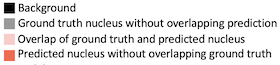

In [ ]:
nuclei_count = halfIoUThresh(root_dir=root_dir, regions_coordinate_dict=regions_coordinate_dict, gr_tr_fname = "gr_tr.tiff", save_qual_imgs=False, print_qual_imgs=False,
              platforms_list=platforms_list)

Bph2_45174_14597_160_246
Bph2_45174_14597_2032_2032
Bph2_45174_14597_2492_682
Bph2_45174_14597_3625_2420
P01_10001_54032_15278_550_400
P01_10002_41478_16613_300_50
P01_10003_59622_10626_650_100
P01_10004_45412_13528_300_300
P01_10005_54191_8632_600_100
P01_10007_43705_10821_700_100
P02_10002_46825_10035_600_1300
P03_10006_53346_12619_2250_50
P03_10006_53346_12619_250_450
P03_10009_53725_9272_570_10
P03_10011_56477_11085_270_0
P04_1002_49602_16360_75_475
P05_10002_50311_5870_1575_325
P05_10004_52117_15632_302_820
P05_10005_59531_13160_875_1075
P05_10006_45458_10695_1270_100
P05_10006_45458_10695_275_1400
P05_10006_45458_10695_380_377
P05_10007_54516_8107_1428_1138
P05_10007_54516_8107_1932_407
P05_10008_53049_13410_2000_400
P05_10008_53049_13410_200_300
P05_9997_47655_5439_1635_607
P05_9997_47655_5439_35_1034
P05_9998_49401_6049_1670_670
P05_9998_49401_6049_480_770
P05_9999_44325_9681_1640_650
P07_10002_53508_14973_400_605
P07_10003_49716_12785_1900_1000
P07_10004_53024_13505_1250_1500


In [5]:
print(f"Total number of ground truth nuclei: {nuclei_count}")

Total number of ground truth nuclei: 20164


The function below generates one csv file for each WSI region/field containing the F1-score for each platform and at varying IoU thresholds specified by <i>IoU_thresh_list</i> above. The csv files are saved in root/F1_multipleIoU_csv. It also has the functionality to generate qualitative visualizations (if save_qual_imgs set to True) of True Positive and False Positive predicted nuclei identified and True Positive and False Negative ground truth nuclei identified. These visualizations will be saved in root/qual_imgs/<b>Field1</b>/F1_visualization where <b>Field1</b> is replaced by the names of the WSI fields in root/fields. The legend below can be used to interpret these qualitative visualizations:


For predictions: 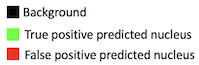


For ground truth: 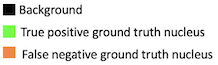


In [6]:
multipleIoUThresh(root_dir=root_dir, regions_coordinate_dict=regions_coordinate_dict,  gr_tr_fname = "gr_tr.tiff", save_qual_imgs=False,
                  platforms_list=platforms_list, IoU_thresh_list=IoU_thresh_list)

<b>Quantitative evaluation visualization using csv files created</b>

The function below uses the csv files generated by the <i>halfIoUThresh</i> function above and saved in root/F1_halfIoU_csv to produce a barplot showing mean and 95% confidence interval (over evaluation sub-regions from all fields) of the F1-score of each platform on the entire dataset of  WSI regions in root/Fields. The barplot is saved in root/halfIoU_evaluation.

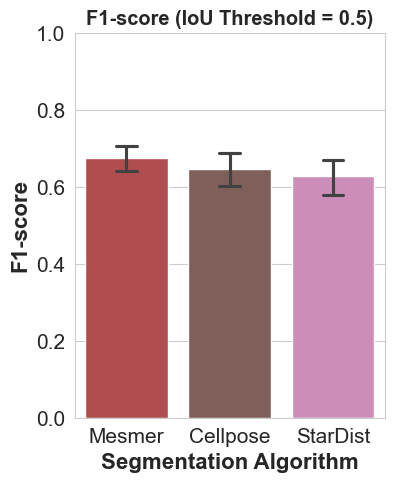

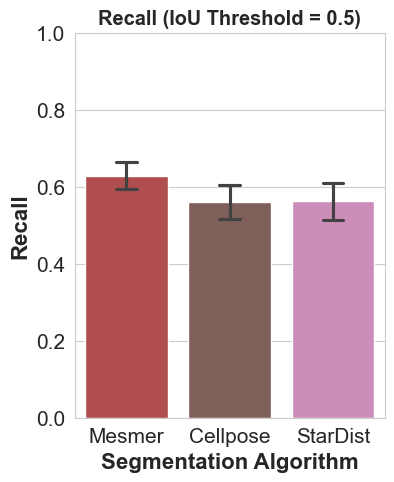

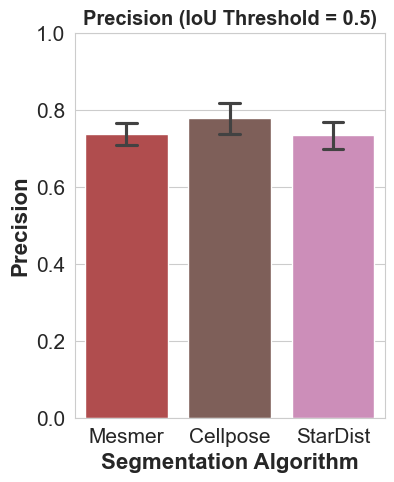

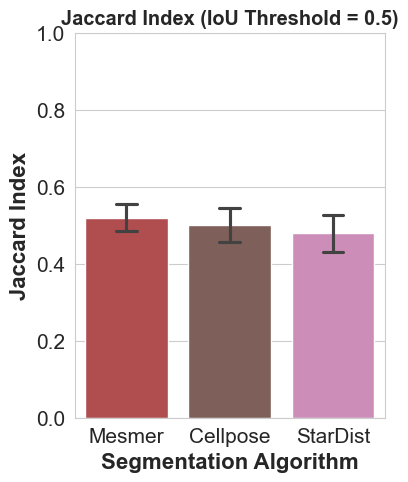

In [7]:
csv_viz_halfIoU(root_dir)

The function below uses the csv files generated by the <i>multipleIoUThresh</i> function above and saved in root/F1_multipleIoU_csv to produce a lineplot showing mean (over evaluation sub-regions from all fields) of the F1-score of each platform, calculated at varying IoU thresholds specified by <i>IoU_thresh_list</i> above, on the entire dataset of  WSI regions in root/Fields. The lineplot is saved in root/multipleIoU_evaluation/multipleIoU_plot.

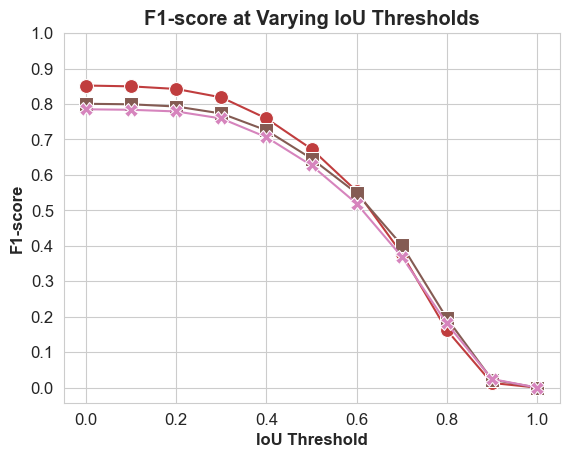

In [8]:
csv_viz_multipleIoU(root_dir)